In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
def import_matlab_data(filename):
    """Taking a Matlab file of Arbin data from the CALCE database and imports it into a host of different NumPy arrays"""
    
    import hdf5storage
    import numpy as np
    import pandas as pd
    
    #Importing the file as a HDF5 dataframe, stored in the form of a dictionary.  
    df = hdf5storage.loadmat(filename)
    return df


def load_matlab_data(filename):
    """Takes a Matlab file of Arbin data from the CALCE database, imports it, and parses it into a dictionary that most
    closely resembles the cell array structure in Matlab"""
    
    import hdf5storage
    import numpy as np
    import pandas as pd
    
    #Calling the imported dataframe. 
    df = import_matlab_data(filename)
    keys = df.keys()
 
    #Creating an empty dictionary. 
    data_dict = {}
    count = 2
    
    # For assigning the correct dictionary keys for the for loops later. 
    for i in keys:
        if i == '#subsystem#':
            pass
        else:
            data = i
    
    for idx in range(1, len(df[data])):
        operation = str(df[data][idx][0][0][0])
        start_date = str(df[data][idx][1][0][0])

        #name = filename.split(".")
        if df[data][idx][2].shape == (0,0):
            pass
        
        else:
            host_df = pd.DataFrame()

            host_df['time'] = df['#subsystem#'][0][0][0][count][0][0].flatten()
            host_df['datetime'] = df['#subsystem#'][0][0][0][count][0][1].flatten()
            host_df['step'] = df['#subsystem#'][0][0][0][count][0][2].flatten()
            host_df['cycle'] = df['#subsystem#'][0][0][0][count][0][3].flatten()
            host_df['current_amp'] = df['#subsystem#'][0][0][0][count][0][4].flatten()
            host_df['voltage'] = df['#subsystem#'][0][0][0][count][0][5].flatten()
            host_df['charge_ah'] = df['#subsystem#'][0][0][0][count][0][6].flatten()
            host_df['discharge_ah'] = df['#subsystem#'][0][0][0][count][0][7].flatten()

            data_dict[operation + ' ' + start_date] = host_df

            count = count + 7

            if count > len(df['#subsystem#'][0][0][0]):
                break
    
    return data_dict

In [38]:
def initialize_datasets(filename, df):
    """this function takes in a dataframe generated from the Matlab files. For the partial discharge curves and 
    initializes the data so that cycle 1 corresponds to the beginning of the partial cycling experiments, and
    not to full charge/discharge data."""
    # Initializing each parameter with the first datasets

    # Will need to do a separate for loop to see if where we initalize the code is correct.
    # Coordinate the count and the index so that if the data series in the count is < 3000, pass and
    # move onto the next index. If it finally gets initialized, then do the for loop to continue in adding
    # all the other mumbo jumbo
    
    df = import_matlab_data(filename)
    keys = df.keys()

    for i in keys:
        if i == '#subsystem#':
            pass
        else:
            data = i
    
    count = 2
    for idx in range(1, len(df[data])):
        time_sum = df['#subsystem#'][0][0][0][count][0][0].flatten()
        if len(time_sum) < 3500:
            count = count + 7
        else:
            datetime_sum = df['#subsystem#'][0][0][0][count][0][1].flatten()
            step_sum = df['#subsystem#'][0][0][0][count][0][2].flatten()
            cycle_sum = df['#subsystem#'][0][0][0][count][0][3].flatten()
            current_sum = df['#subsystem#'][0][0][0][count][0][4].flatten()
            voltage_sum = df['#subsystem#'][0][0][0][count][0][5].flatten()
            charge_ah_sum = df['#subsystem#'][0][0][0][count][0][6].flatten()
            discharge_ah_sum = df['#subsystem#'][0][0][0][count][0][7].flatten()
            count = count + 7
            break
    
    return count, idx, time_sum, datetime_sum, step_sum, cycle_sum, current_sum, voltage_sum, charge_ah_sum, discharge_ah_sum

In [45]:
#This is the function we use, not the load_matlab one. 

def single_pd_matlab_data(filename):
    
    df = import_matlab_data(filename)
    keys = df.keys()

    for i in keys:
        if i == '#subsystem#':
            pass
        else:
            data = i
            
    count, idx, time_sum, datetime_sum, step_sum, cycle_sum, current_sum, voltage_sum, charge_ah_sum, discharge_ah_sum = initialize_datasets(filename, df)
    start_ind = idx + 1
    #time_sum = df['#subsystem#'][0][0][0][2][0][0].flatten()
    #datetime_sum = df['#subsystem#'][0][0][0][2][0][1].flatten()
    #step_sum = df['#subsystem#'][0][0][0][2][0][2].flatten()
    #cycle_sum = df['#subsystem#'][0][0][0][2][0][3].flatten()
    #current_sum = df['#subsystem#'][0][0][0][2][0][4].flatten()
    #voltage_sum = df['#subsystem#'][0][0][0][2][0][5].flatten()
    #charge_ah_sum = df['#subsystem#'][0][0][0][2][0][6].flatten()
    #discharge_ah_sum = df['#subsystem#'][0][0][0][2][0][7].flatten()
    #count = 9

    for idx in range(int(start_ind), len(df[data])):
        length_test = (df['#subsystem#'][0][0][0][count][0][0].flatten())
        #To access the number of cycles in each dataset. 
        
        #For missing data. 
        if df[data][idx][2].shape == (0,0):
            name = df[data][idx][0][0][0]
            name = name.split(' ')
            number = float(name[0])
            cycle_sum = np.append(cycle_sum, (cycle_sum[-1] + number))
        elif len(length_test) < 3100:
            count = count + 7
        else:
            time_idx = (df['#subsystem#'][0][0][0][count][0][0].flatten()) + time_sum[-1]
            time_sum = np.concatenate((time_sum, time_idx), axis = 0)

            datetime_idx = df['#subsystem#'][0][0][0][count][0][1].flatten()
            datetime_sum = np.concatenate((datetime_sum, datetime_idx), axis = 0)

            step_idx = df['#subsystem#'][0][0][0][count][0][2].flatten()
            step_sum = np.concatenate((step_sum, step_idx), axis = 0)

            if len(cycle_sum) > len(current_sum):
                diff = len(cycle_sum) - len(current_sum)
                cycle_prior = cycle_sum[-1]
                for i in range(0,diff):
                    cycle_sum = np.delete(cycle_sum, -1)
                cycle_idx = (df['#subsystem#'][0][0][0][count][0][3].flatten()) + cycle_prior
                cycle_test = (df['#subsystem#'][0][0][0][count][0][3].flatten())
                cycle_sum = np.concatenate((cycle_sum, cycle_idx), axis = 0)
            else:
                cycle_prior = cycle_sum[-1]
                cycle_idx = (df['#subsystem#'][0][0][0][count][0][3].flatten()) + cycle_prior
                cycle_test = (df['#subsystem#'][0][0][0][count][0][3].flatten())
                cycle_sum = np.concatenate((cycle_sum, cycle_idx), axis = 0)

            current_idx = df['#subsystem#'][0][0][0][count][0][4].flatten()
            current_sum = np.concatenate((current_sum, current_idx), axis = 0)

            voltage_idx = df['#subsystem#'][0][0][0][count][0][5].flatten()
            voltage_sum = np.concatenate((voltage_sum, voltage_idx), axis = 0)

            charge_ah_idx = df['#subsystem#'][0][0][0][count][0][6].flatten()
            charge_ah_sum = np.concatenate((charge_ah_sum, charge_ah_idx), axis = 0)

            discharge_ah_idx = df['#subsystem#'][0][0][0][count][0][7].flatten()
            discharge_ah_sum = np.concatenate((discharge_ah_sum, discharge_ah_idx), axis = 0)

            count = count + 7

            if count > (len(df['#subsystem#'][0][0][0])-7):
                break


    host_df = pd.DataFrame()

    host_df['time'] = time_sum
    host_df['datetime'] = datetime_sum
    host_df['step'] = step_sum
    host_df['cycle'] = cycle_sum
    host_df['current_amp'] = current_sum
    host_df['voltage'] = voltage_sum
    host_df['charge_ah'] = charge_ah_sum
    host_df['discharge_ah'] = discharge_ah_sum
    
    return host_df


In [46]:
single_pd_matlab_data('converted_PL04.mat')

,time,datetime,step,cycle,current_amp,voltage,charge_ah,discharge_ah
0,5.001206e+00,735943.609988,1.0,1.0,0.000000,4.193179,0.000000e+00,0.000000
1,1.000122e+01,735943.610046,1.0,1.0,0.000000,4.193179,0.000000e+00,0.000000
2,1.501731e+01,735943.610104,1.0,1.0,0.000000,4.193179,0.000000e+00,0.000000
3,2.003158e+01,735943.610162,1.0,1.0,0.000000,4.193179,0.000000e+00,0.000000
4,2.503274e+01,735943.610220,1.0,1.0,0.000000,4.193340,0.000000e+00,0.000000
5,3.003284e+01,735943.610278,1.0,1.0,0.000000,4.193179,0.000000e+00,0.000000
6,3.504761e+01,735943.610336,1.0,1.0,0.000000,4.193179,0.000000e+00,0.000000
7,4.004807e+01,735943.610394,1.0,1.0,0.000000,4.193340,0.000000e+00,0.000000
8,4.504833e+01,735943.610451,1.0,1.0,0.000000,4.193340,0.000000e+00,0.000000
9,5.006316e+01,735943.610509,1.0,1.0,0.000000,4.193340,0.000000e+00,0.000000


In [47]:
def sort_by_cycle(filename):
    
    df = single_pd_matlab_data(filename)
    
    cycle_dict = {}
    cycle_list = df['cycle'].unique()

    for idx in list(cycle_list):
        if idx not in cycle_dict.keys():
            cycle_dict[idx] = df.loc[df['cycle'] == idx]
        else:
            pass
    
    return cycle_dict    
    

In [48]:
def sort_charge_discharge(cycle_dict):
    
    #cycle_dict = sort_by_cycle(filename)
    
    charge_dict = {}
    discharge_dict = {}
    
    for idx in list(cycle_dict.keys()):
        if idx not in charge_dict.keys():
            charge_pred = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] > 0]
            disc_pred = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] < 0]
            #charge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] > 0]
            charge_dict[idx] = charge_pred
            charge_dict[idx] = charge_dict[idx].drop(charge_dict[idx].tail(1).index)
            #discharge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] < 0]
            discharge_dict[idx] = disc_pred
            discharge_dict[idx] = discharge_dict[idx].drop(discharge_dict[idx].head(1).index)
            #diff = charge_dict[idx].iloc[-1][0] - charge_dict[idx].iloc[-2][0]
            #if diff > 100:
            #    charge_dict[idx].drop(charge_dict[idx].tail(1).index, inplace = True)
            #else:
            #    pass
            #
            #diff2 = discharge_dict[idx].iloc[-1][0] - discharge_dict[idx].iloc[-2][0]
            #if diff2 > 100:
            #    discharge_dict[idx].drop(charge_dict[idx].tail(1).index, inplace = True)
            #else:
            #    pass
        else:
            pass
    print (len(cycle_dict.keys()))
    print (len(charge_dict.keys()))
    print (len(discharge_dict.keys()))
    return charge_dict, discharge_dict

In [49]:
p = sort_by_cycle('converted_PL04.mat')

In [ ]:
#charge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] > 0]
if charge_pred.shape[0] < 3100:
pass
else:
charge_dict[idx] = charge_pred
charge_dict[idx] = charge_dict[idx].drop(charge_dict[idx].tail(1).index)
#discharge_dict[idx] = cycle_dict[idx].loc[cycle_dict[idx]['current_amp'] < 0]
if disc_pred.shape[0] < 3100:
pass
else:
discharge_dict[idx] = disc_pred
discharge_dict[idx] = discharge_dict[idx].drop(discharge_dict[idx].head(1).index)

In [50]:
PL11_charge, PL11_discharge = sort_charge_discharge(p)

1905
1905
1905


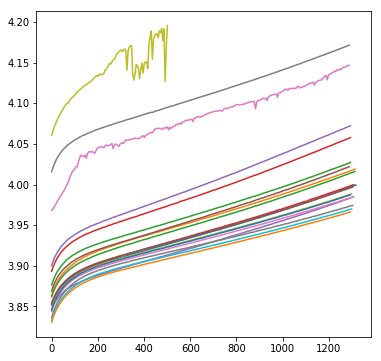

In [53]:
plt.figure(figsize = (6, 6))
for i in range(25,900,36):
    if i in PL11_charge.keys():
        plt.plot((PL11_charge[i]['time']-PL11_charge[i]['time'].iloc[0]), PL11_charge[i]['voltage'])
    else:
        pass
plt.show()

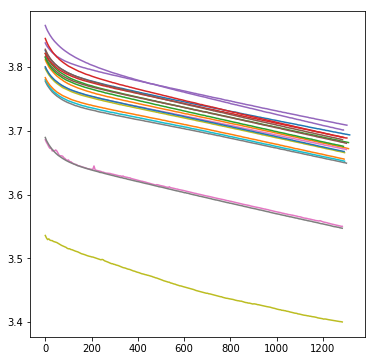

In [54]:
plt.figure(figsize = (6, 6))
for i in range(25,900,36):
    if i in PL11_discharge.keys():
        plt.plot((PL11_discharge[i]['time']-PL11_discharge[i]['time'].iloc[0]), PL11_discharge[i]['voltage'])
    else:
        pass
plt.show()